## System Dynamics

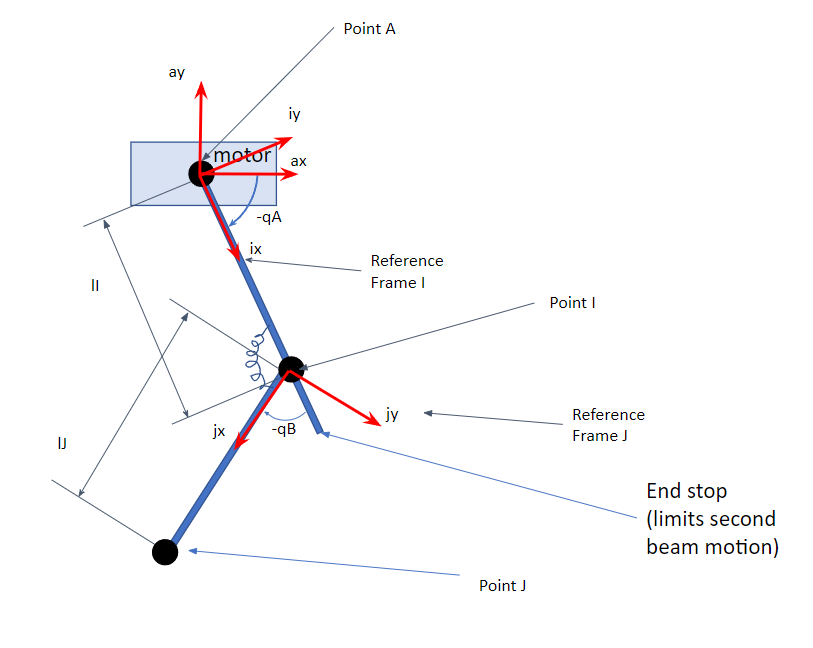

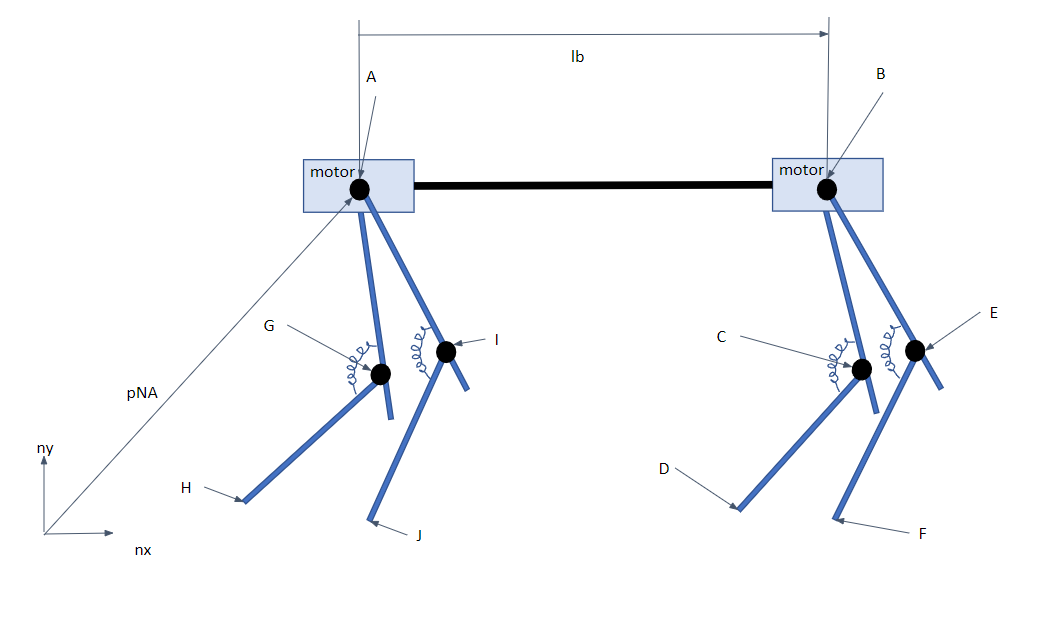

In [ ]:
!pip install pynamics
%matplotlib inline
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
from pynamics.particle import Particle
from pynamics.constraint import AccelerationConstraint
import pynamics.integration
import numpy
import sympy
import matplotlib.pyplot as plt
plt.ion()
from math import pi

In [ ]:
system=System()
pynamics.set_system(__name__,system)

In [ ]:
#lenghts in m
lB = Constant(.15,'lB',system)
lC = Constant(.05,'lC',system)
lD = Constant(.05,'lD',system)
lE = Constant(.05,'lE',system)
lF = Constant(.05,'lF',system)
lG = Constant(.05,'lG',system)
lH = Constant(.05,'lH',system)
lI = Constant(.05,'lI',system)
lJ = Constant(.05,'lJ',system)

#masses in kg
mB = Constant(.5,'mB',system)
mC = Constant(.01,'mC',system)
mD = Constant(.01,'mD',system)
mE = Constant(.01,'mE',system)
mF = Constant(.01,'mF',system)
mG = Constant(.01,'mG',system)
mH = Constant(.01,'mH',system)
mI = Constant(.01,'mI',system)
mJ = Constant(.01,'mJ',system)

g = Constant(9.81,'g',system)     #Gravity 
b = Constant(1e-4,'b',system)
k = Constant(1e-2,'k',system)
kEndStop = Constant(1e1,'kEndStop',system)
bEndStop = Constant(1e-1,'bEndStop',system)
preload1 = Constant(-80*pi/180,'preload1',system)
preload2 = Constant(-15*pi/180,'preload2',system)

#end stop limits
limit = Constant(-(-0*pi/180),'limit',system)


#Inertial values that describe the dyatics/inertia of the rigid bodies about x, y and z axes 
Ixx_B = Constant(1e-1,'Ixx_B',system)
Iyy_B = Constant(1e-1,'Iyy_B',system)
Izz_B = Constant(1e-1,'Izz_B',system)
Ixx_C = Constant(1e-2,'Ixx_C',system)
Iyy_C = Constant(1e-2,'Iyy_C',system)
Izz_C = Constant(1e-2,'Izz_C',system)
Ixx_D = Constant(1e-2,'Ixx_D',system)
Iyy_D = Constant(1e-2,'Iyy_D',system)
Izz_D = Constant(1e-2,'Izz_D',system)
Ixx_E = Constant(1e-2,'Ixx_E',system)
Iyy_E = Constant(1e-2,'Iyy_E',system)
Izz_E = Constant(1e-2,'Izz_E',system)
Ixx_F = Constant(1e-2,'Ixx_F',system)
Iyy_F = Constant(1e-2,'Iyy_F',system)
Izz_F = Constant(1e-2,'Izz_F',system)
Ixx_G = Constant(1e-2,'Ixx_G',system)
Iyy_G = Constant(1e-2,'Iyy_G',system)
Izz_G = Constant(1e-2,'Izz_G',system)
Ixx_H = Constant(1e-2,'Ixx_H',system)
Iyy_H = Constant(1e-2,'Iyy_H',system)
Izz_H = Constant(1e-2,'Izz_H',system)
Ixx_I = Constant(1e-2,'Ixx_I',system)
Iyy_I = Constant(1e-2,'Iyy_I',system)
Izz_I = Constant(1e-2,'Izz_I',system)
Ixx_J = Constant(1e-2,'Ixx_J',system)
Iyy_J = Constant(1e-2,'Iyy_J',system)
Izz_J = Constant(1e-2,'Izz_J',system)


torque = Constant(0,'torque',system)
freq = Constant(3e0,'freq',system)  #3e0 means 3Hz

In [ ]:
#3 state variables:
qC,qC_d,qC_dd = Differentiable('qC',system)
qD,qD_d,qD_dd = Differentiable('qD',system)
qE,qE_d,qE_dd = Differentiable('qE',system)
qF,qF_d,qF_dd = Differentiable('qF',system)
qG,qG_d,qG_dd = Differentiable('qG',system)
qH,qH_d,qH_dd = Differentiable('qH',system)
qI,qI_d,qI_dd = Differentiable('qI',system)
qJ,qJ_d,qJ_dd = Differentiable('qJ',system)

# state variables for body position and rotation
Ax,Ax_d,Ax_dd = Differentiable('Ax',system)
Ay,Ay_d,Ay_dd = Differentiable('Ay',system)
Aq,Aq_d,Aq_dd = Differentiable('Aq',system)

In [ ]:
initialvalues = {}
initialvalues[Aq]=0*pi/180
initialvalues[Aq_d]=0*pi/180
initialvalues[Ax]=0
initialvalues[Ax_d]=0
initialvalues[Ay]=0.1
initialvalues[Ay_d]=0

initialvalues[qC]=-60*pi/180
initialvalues[qC_d]=0*pi/180
initialvalues[qD]=-15*pi/180
initialvalues[qD_d]=0*pi/180
initialvalues[qE]=-50*pi/180
initialvalues[qE_d]=0*pi/180
initialvalues[qF]=-15*pi/180
initialvalues[qF_d]=0*pi/180
initialvalues[qG]=-40*pi/180
initialvalues[qG_d]=0*pi/180
initialvalues[qH]=-15*pi/180
initialvalues[qH_d]=0*pi/180
initialvalues[qI]=-70*pi/180
initialvalues[qI_d]=0*pi/180
initialvalues[qJ]=-15*pi/180
initialvalues[qJ_d]=0*pi/180


In [ ]:
statevariables = system.get_state_variables()
ini = [initialvalues[item] for item in statevariables]

In [ ]:
#Defining reference frames of the system 
N = Frame('N',system)
A = Frame('A',system)

C = Frame('C',system)
D = Frame('D',system)
E = Frame('E',system)
F = Frame('F',system)
G = Frame('G',system)
H = Frame('H',system)
I = Frame('I',system)
J = Frame('J',system)

In [ ]:
system.set_newtonian(N)
A.rotate_fixed_axis(N,[0,0,1],Aq,system)

In [ ]:
#legs attacheced to body
C.rotate_fixed_axis(A,[0,0,1],qC,system)
E.rotate_fixed_axis(A,[0,0,1],qE,system)
G.rotate_fixed_axis(A,[0,0,1],qG,system)
I.rotate_fixed_axis(A,[0,0,1],qI,system)

#legs attacheced to legs
D.rotate_fixed_axis(C,[0,0,1],qD,system)
F.rotate_fixed_axis(E,[0,0,1],qF,system)
H.rotate_fixed_axis(G,[0,0,1],qH,system)
J.rotate_fixed_axis(I,[0,0,1],qJ,system)

In [ ]:
pNO=0*N.x
#body
pNA = Ax*N.x + Ay*N.y
pAB = pNA + lB*A.x
#legs
pBC = pAB + lC*C.x
pCD = pBC + lD*D.x

pBE = pAB + lE*E.x
pEF = pBE + lF*F.x

pAI = pNA + lI*I.x
pIJ = pAI + lJ*J.x 

pAG = pNA + lG*G.x
pGH = pAG + lH*H.x 


In [ ]:
#Center of mass
pAcm=pNA+lB/2*A.x  
pCcm = pBC - lC/2*C.x
pDcm = pCD - lD/2*D.x
pEcm = pBE - lE/2*E.x
pFcm = pEF - lF/2*F.x
pIcm = pAI - lI/2*I.x
pJcm = pIJ - lJ/2*J.x
pGcm = pAG - lG/2*G.x
pHcm = pGH - lH/2*H.x

In [ ]:
#Angular velocity
wNA = N.get_w_to(A) 

wAC = A.get_w_to(C)
wAE = A.get_w_to(E)
wAI = A.get_w_to(I)
wAG = A.get_w_to(G)

wCD = C.get_w_to(D)
wEF = E.get_w_to(F)
wIJ = I.get_w_to(J)
wGH = G.get_w_to(H)


In [ ]:
#vBtip = pBtip.time_derivative(N,system)

In [ ]:
IA = Dyadic.build(A,Ixx_B,Iyy_B,Izz_B)
IC = Dyadic.build(C,Ixx_C,Iyy_C,Izz_C)
ID = Dyadic.build(D,Ixx_D,Iyy_D,Izz_D)
IE = Dyadic.build(E,Ixx_E,Iyy_E,Izz_E)
IF = Dyadic.build(F,Ixx_F,Iyy_F,Izz_F)
IG = Dyadic.build(G,Ixx_G,Iyy_G,Izz_G)
IH = Dyadic.build(H,Ixx_H,Iyy_H,Izz_H)
II = Dyadic.build(I,Ixx_I,Iyy_I,Izz_I)
IJ = Dyadic.build(J,Ixx_J,Iyy_J,Izz_J)


BodyA = Body('BodyA',A,pAcm,mB,IA,system)
BodyC = Body('BodyC',C,pCcm,mC,IC,system)
BodyD = Body('BodyD',D,pDcm,mD,ID,system)
BodyE = Body('BodyE',E,pEcm,mE,IE,system)
BodyF = Body('BodyF',F,pFcm,mF,IF,system)
BodyG = Body('BodyG',G,pGcm,mG,IG,system)
BodyH = Body('BodyH',H,pHcm,mH,IH,system)
BodyI = Body('BodyI',I,pIcm,mI,II,system)
BodyJ = Body('BodyJ',J,pJcm,mJ,IJ,system)


In [ ]:
# Damper forces
system.addforce(-b*wAC,wAC)
system.addforce(-b*wAE,wAE)
system.addforce(-b*wAI,wAI)
system.addforce(-b*wAG,wAG)

system.addforce(-b*wCD,wCD)
system.addforce(-b*wEF,wEF)
system.addforce(-b*wIJ,wIJ)
system.addforce(-b*wGH,wGH)


In [ ]:
#Spring forces
system.add_spring_force1(k,(qC-preload1)*A.z,wAC)
system.add_spring_force1(k,(qD-preload2)*C.z,wCD)

system.add_spring_force1(k,(qE-preload1)*A.z,wAE)
system.add_spring_force1(k,(qF-preload2)*E.z,wEF)

system.add_spring_force1(k,(qI-preload1)*A.z,wAI)
system.add_spring_force1(k,(qJ-preload2)*C.z,wIJ)

system.add_spring_force1(k,(qG-preload1)*A.z,wAG)
system.add_spring_force1(k,(qH-preload2)*C.z,wGH)


(<pynamics.force.Force at 0x7f13da55d2d0>,
 <pynamics.spring.Spring at 0x7f13da55d550>)

In [ ]:
#end Stops
system.add_spring_force1(kEndStop,((abs(qD+limit)+qD+limit)/(2*(qD+limit)))*(qD+limit)*C.z,wCD)
system.add_spring_force1(kEndStop,((abs(qF+limit)+qF+limit)/(2*(qF+limit)))*(qF+limit)*E.z,wEF)
system.add_spring_force1(kEndStop,((abs(qJ+limit)+qJ+limit)/(2*(qJ+limit)))*(qJ+limit)*I.z,wIJ)
system.add_spring_force1(kEndStop,((abs(qH+limit)+qH+limit)/(2*(qH+limit)))*(qH+limit)*G.z,wGH)

#end Stop Damping
system.addforce(-bEndStop*((abs(qD+limit)+qD+limit)/(2*(qD+limit)))*wCD,wCD)
system.addforce(-bEndStop*((abs(qF+limit)+qF+limit)/(2*(qF+limit)))*wEF,wEF)
system.addforce(-bEndStop*((abs(qJ+limit)+qJ+limit)/(2*(qJ+limit)))*wIJ,wIJ)
system.addforce(-bEndStop*((abs(qH+limit)+qH+limit)/(2*(qH+limit)))*wGH,wGH)

In [ ]:
#constraning AB not to fall

eq = []
eq.append(.1*N.y - pNA)
eq.append(.1*N.y+.15*N.x - pAB)

eq_scalar = []
eq_scalar.append(eq[0].dot(N.x))
eq_scalar.append(eq[0].dot(N.y))
#eq_scalar.append(eq[1].dot(N.x))
eq_scalar.append(eq[1].dot(N.y))

eq_d = [item.time_derivative() for item in eq]
eq_dd = [item.time_derivative() for item in eq_d]
eq_dd_scalar = []
eq_dd_scalar.append(eq_dd[0].dot(N.x))
eq_dd_scalar.append(eq_dd[0].dot(N.y))
#eq_dd_scalar.append(eq_dd[1].dot(N.x))
eq_dd_scalar.append(eq_dd[1].dot(N.y))

system.add_constraint(AccelerationConstraint(eq_dd_scalar))

In [ ]:
system.addforcegravity(-g*N.y)

In [ ]:
f,ma = system.getdynamics()

2022-03-05 21:05:41,636 - pynamics.system - INFO - getting dynamic equations


In [ ]:
f

[-b*qC_d + g*lC*mC*sin(Aq)*sin(qC)/2 - g*lC*mC*cos(Aq)*cos(qC)/2 + g*lC*mD*sin(Aq)*sin(qC) - g*lC*mD*cos(Aq)*cos(qC) - g*lD*mD*(-sin(qC)*sin(qD) + cos(qC)*cos(qD))*cos(Aq)/2 - g*lD*mD*(-sin(qC)*cos(qD) - sin(qD)*cos(qC))*sin(Aq)/2 - k*(-preload1 + qC), -b*qD_d - bEndStop*qD_d*(limit + qD + Abs(limit + qD))/(2*limit + 2*qD) - g*lD*mD*(-sin(qC)*sin(qD) + cos(qC)*cos(qD))*cos(Aq)/2 - g*lD*mD*(-sin(qC)*cos(qD) - sin(qD)*cos(qC))*sin(Aq)/2 - k*(-preload2 + qD) - kEndStop*(limit + qD)*(limit + qD + Abs(limit + qD))/(2*limit + 2*qD), -b*qE_d + g*lE*mE*sin(Aq)*sin(qE)/2 - g*lE*mE*cos(Aq)*cos(qE)/2 + g*lE*mF*sin(Aq)*sin(qE) - g*lE*mF*cos(Aq)*cos(qE) - g*lF*mF*(-sin(qE)*sin(qF) + cos(qE)*cos(qF))*cos(Aq)/2 - g*lF*mF*(-sin(qE)*cos(qF) - sin(qF)*cos(qE))*sin(Aq)/2 - k*(-preload1 + qE), -b*qF_d - bEndStop*qF_d*(limit + qF + Abs(limit + qF))/(2*limit + 2*qF) - g*lF*mF*(-sin(qE)*sin(qF) + cos(qE)*cos(qF))*cos(Aq)/2 - g*lF*mF*(-sin(qE)*cos(qF) - sin(qF)*cos(qE))*sin(Aq)/2 - k*(-preload2 + qF) - kEndSt

In [ ]:
ma

[Izz_C*(Aq_dd + qC_dd) + Izz_D*(Aq_dd + qC_dd + qD_dd) + lB*lC*mC*Aq_d**2*sin(qC)/2 + lB*lC*mC*Aq_dd*cos(qC)/2 + lB*lC*mD*Aq_d**2*sin(qC) + lB*lC*mD*Aq_dd*cos(qC) + lC*lD*mD*(Aq_d + qC_d)**2*sin(qD)/2 - lC*lD*mD*(Aq_d + qC_d + qD_d)**2*sin(qD)/2 + lC*mC*(lC*Aq_dd/2 + lC*qC_dd/2)/2 + lC*mD*(lC*Aq_dd + lC*qC_dd) + lC*mD*(lD*Aq_dd/2 + lD*qC_dd/2 + lD*qD_dd/2)*cos(qD) + lC*(-mC*Ax_dd*sin(Aq) + mC*Ay_dd*cos(Aq))*cos(qC)/2 - lC*(mC*Ax_dd*cos(Aq) + mC*Ay_dd*sin(Aq))*sin(qC)/2 + lC*(-mD*Ax_dd*sin(Aq) + mD*Ay_dd*cos(Aq))*cos(qC) - lC*(mD*Ax_dd*cos(Aq) + mD*Ay_dd*sin(Aq))*sin(qC) + lD*mD*(lC*Aq_dd + lC*qC_dd)*cos(qD)/2 + lD*mD*(lD*Aq_dd/2 + lD*qC_dd/2 + lD*qD_dd/2)/2 + lD*(-sin(qC)*sin(qD) + cos(qC)*cos(qD))*(-mD*Ax_dd*sin(Aq) + mD*Ay_dd*cos(Aq))/2 + lD*(-sin(qC)*cos(qD) - sin(qD)*cos(qC))*(mD*Ax_dd*cos(Aq) + mD*Ay_dd*sin(Aq))/2 + lD*(lB*mD*Aq_d**2*sin(qC) + lB*mD*Aq_dd*cos(qC))*cos(qD)/2 - lD*(-lB*mD*Aq_d**2*cos(qC) + lB*mD*Aq_dd*sin(qC))*sin(qD)/2, Izz_D*(Aq_dd + qC_dd + qD_dd) + lC*lD*mD*(Aq_

In [ ]:
func1,lambda1 = system.state_space_post_invert(f,ma,return_lambda = True)


2022-03-05 21:05:47,232 - pynamics.system - INFO - solving a = f/m and creating function
2022-03-05 21:05:55,003 - pynamics.system - INFO - substituting constrained in Ma-f.
2022-03-05 21:05:56,788 - pynamics.system - INFO - done solving a = f/m and creating function
2022-03-05 21:05:56,791 - pynamics.system - INFO - calculating function for lambdas


In [ ]:
tol = 1e-5


In [ ]:
tinitial = 0
tfinal = 10
fps = 30
tstep = 1/fps
t = numpy.r_[tinitial:tfinal:tstep]

In [ ]:
states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol, args=({'constants':system.constant_values},))


2022-03-05 21:05:57,270 - pynamics.integration - INFO - beginning integration
2022-03-05 21:05:57,278 - pynamics.system - INFO - integration at time 0000.00
2022-03-05 21:06:03,642 - pynamics.system - INFO - integration at time 0003.32
2022-03-05 21:06:09,849 - pynamics.system - INFO - integration at time 0007.40
2022-03-05 21:06:15,816 - pynamics.system - INFO - integration at time 0008.04
2022-03-05 21:06:16,002 - pynamics.integration - INFO - finished integration


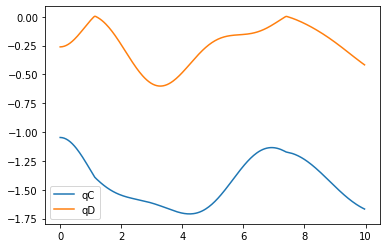

In [ ]:
plt.figure()
artists = plt.plot(t,states[:,:2])
plt.legend(artists,['qC','qD'])

2022-03-05 21:06:17,567 - pynamics.output - INFO - calculating outputs
2022-03-05 21:06:17,794 - pynamics.output - INFO - done calculating outputs


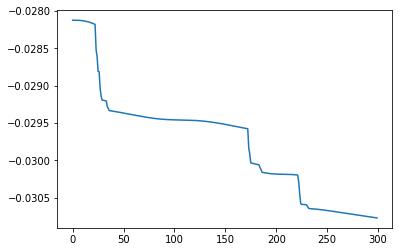

In [ ]:
KE = system.get_KE()
PE = system.getPEGravity(pNA) - system.getPESprings()
energy_output = Output([KE-PE],system)
energy_output.calc(states,t)
energy_output.plot_time()

2022-03-05 21:06:18,537 - pynamics.output - INFO - calculating outputs
2022-03-05 21:06:18,744 - pynamics.output - INFO - done calculating outputs


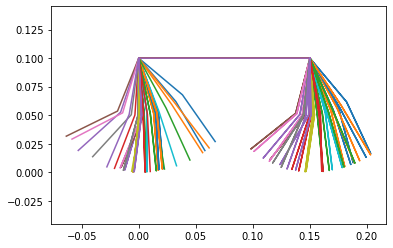

In [ ]:
points = [pAB,pBC,pCD,pBC,pAB,pBE,pEF,pBE,pAB,pNA,pAI,pIJ,pAI,pNA,pAG,pGH]
points_output = PointsOutput(points,system)
y = points_output.calc(states,t)
points_output.plot_time(20)

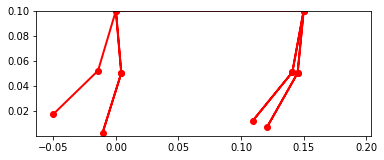

In [ ]:
points_output.animate(fps = fps,movie_name = 'triple_pendulum.mp4',lw=2,marker='o',color=(1,0,0,1),linestyle='-')


In [ ]:
from matplotlib import animation, rc
from IPython.display import HTML
HTML(points_output.anim.to_html5_video())